In [ ]:
!pip install wandb -q

In [13]:
!git clone https://github.com/amir7d0/InfoGAN.git
!cp -r InfoGAN/infogan .

Cloning into 'InfoGAN'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 205 (delta 84), reused 176 (delta 58), pack-reused 0
Receiving objects: 100% (205/205), 2.41 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (84/84), done.


## Train InfoGAN Model

In [2]:

import tensorflow as tf
import os
import wandb

from infogan.models.mnist_models import get_discriminator_model, get_generator_model, get_recognition_model
from infogan.datasets import get_dataset
from infogan.infogan_model_openai import InfoGAN
from infogan.config import config
from infogan.distributions import Uniform, Categorical
from infogan.utils import InfoGANMonitor, InfoGANCheckpoint, InfoGANCSVLogger

tf.config.run_functions_eagerly(True)


if __name__ == "__main__":
    if config.wandb_api_key:
        wandb.login(key=config.wandb_api_key)
        wandb.init(project=f'InfoGAN_{config.dataset_name}')
    
    log_dir = os.path.join(config.root_log_dir, config.dataset_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, config.dataset_name)
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    # load dataset
    mnist_dataset = get_dataset(config.dataset_name, config.batch_size)
    dataset = mnist_dataset.get_dataset()

    # define latent codes specification
    latent_spec = {
        'noise-variables': [Uniform(62)],    # for `noise-variables` just specify one dist in list format
        'continuous-latent-codes': [Uniform(1), Uniform(1)],
        'discrete-latent-codes': [Categorical(10)]
    }
    noise_len = sum([sum([x.dim for x in xx]) for xx in latent_spec.values()])
    generator = get_generator_model([noise_len])
    discriminator = get_discriminator_model(mnist_dataset.image_shape)
    recognition = get_recognition_model([discriminator.output[1].shape[1]], latent_spec)

    info_gan = InfoGAN(
        generator=generator, discriminator=discriminator, recognition=recognition,
        latent_spec=latent_spec, 
        discrete_reg_coeff=config.lambda_disc, 
        continuous_reg_coeff=config.lambda_cont)

    ## Restore the latest checkpoint
    # checkpoint = tf.train.Checkpoint(info_gan)
    # checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    ## or
    # save_path = 'ckt/mnist/training_checkpoints-x'
    # checkpoint.restore(save_path)

    info_gan.compile(
        g_optimizer=tf.keras.optimizers.Adam(config.gen_lr, 0.5),
        d_optimizer=tf.keras.optimizers.Adam(config.dis_lr, 0.5),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
    )
    monitor_cbk = InfoGANMonitor(latent_spec=latent_spec, log_dir=log_dir)
    checkpoint_cbk = InfoGANCheckpoint(checkpoint_dir)
    csv_logger_cbk = InfoGANCSVLogger(filename=f'{config.root_log_dir}/{config.dataset_name}-loss.csv',
                                      separator=",", append=True)

    info_gan.fit(dataset, epochs=config.epochs, callbacks=[
        monitor_cbk, checkpoint_cbk,
        csv_logger_cbk,
        wandb.keras.WandbMetricsLogger(log_freq='batch')]
        )
    


wandb: Currently logged in as: amir7d0. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Number of examples: 60000
Shape of the images in the dataset: (28, 28)
Epoch 1/50
469/469 [==============================] - 158s 332ms/step - G_loss: 1.2351 - D_loss: 0.6450 - MI: 1.9355 - Cross_Ent: 3.3277
Epoch 2/50
469/469 [==============================] - 149s 318ms/step - G_loss: 0.9626 - D_loss: 1.0321 - MI: 3.7772 - Cross_Ent: 1.4858
Epoch 3/50
469/469 [==============================] - 147s 312ms/step - G_loss: 0.9916 - D_loss: 0.9992 - MI: 5.2289 - Cross_Ent: 0.0345
Epoch 4/50
469/469 [==============================] - 144s 306ms/step - G_loss: 1.0994 - D_loss: 0.9283 - MI: 6.1780 - Cross_Ent: -0.9150
Epoch 5/50
469/469 [==============================] - 144s 307ms/step - G_loss: 1.3225 - D_loss: 0.8849 - MI: 6.8773 - Cross_Ent: -1.6141
Epoch 6/50
469/469 [==============================] - 146s 311ms/step - G_loss: 1.5209 - D_loss: 0.7460 - MI: 6.9153 - Cross_Ent: -1.6519
Epoch 7/50
469/469 [==============================] - 143s 305ms/step - G_loss: 1.5673 - D_loss: 0.9232 

## Generate Images

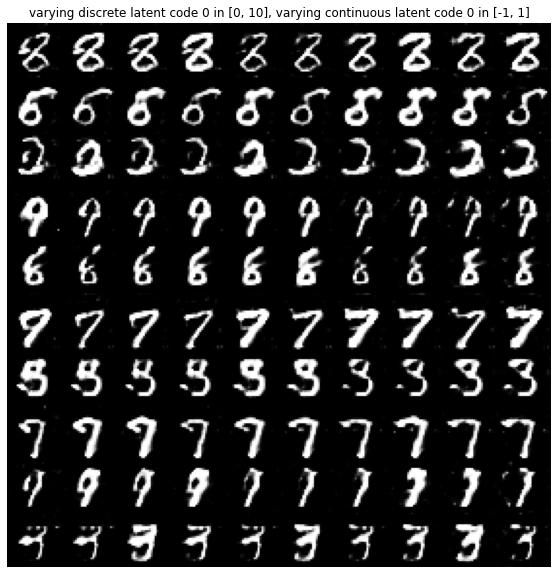

In [7]:
from infogan.utils import plot_test

plot_test(info_gan.generator, latent_spec, 
          idx_range_varying_disc=(0, [0, 10]), 
          idx_range_varying_cont=(0, [-1, 1]))

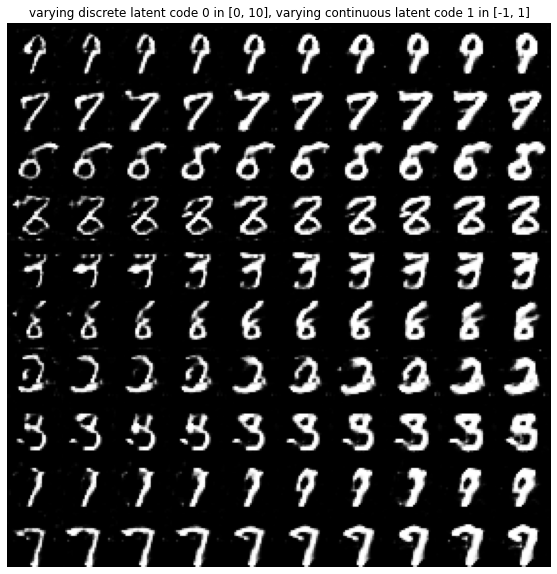

In [8]:

plot_test(info_gan.generator, latent_spec, 
          idx_range_varying_disc=(0, [0, 10]), 
          idx_range_varying_cont=(1, [-1, 1]))

## Restore Trained Model

In [ ]:

import tensorflow as tf
import os
import wandb

from infogan.models.mnist_models import get_discriminator_model, get_generator_model, get_recognition_model
from infogan.datasets import get_dataset
from infogan.infogan_model_openai import InfoGAN
from infogan.config import config
from infogan.distributions import Uniform, Categorical
from infogan.utils import InfoGANMonitor, InfoGANCheckpoint, InfoGANCSVLogger

tf.config.run_functions_eagerly(True)


if __name__ == "__main__":
    
    # load dataset
    mnist_dataset = get_dataset(config.dataset_name, config.batch_size)
    dataset = mnist_dataset.get_dataset()

    # define latent codes specification
    latent_spec = {
        'noise-variables': [Uniform(62)],    # for `noise-variables` just specify one dist in list format
        'continuous-latent-codes': [Uniform(1), Uniform(1)],
        'discrete-latent-codes': [Categorical(10)]
    }
    noise_len = sum([sum([x.dim for x in xx]) for xx in latent_spec.values()])
    generator = get_generator_model([noise_len])
    discriminator = get_discriminator_model(mnist_dataset.image_shape)
    recognition = get_recognition_model([discriminator.output[1].shape[1]], latent_spec)

    info_gan = InfoGAN(
        generator=generator, discriminator=discriminator, recognition=recognition,
        latent_spec=latent_spec, 
        discrete_reg_coeff=config.lambda_disc, 
        continuous_reg_coeff=config.lambda_cont)

    ## Restore the latest checkpoint
    checkpoint = tf.train.Checkpoint(info_gan)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    ## or
    # save_path = 'ckt/mnist/training_checkpoints-x'
    # checkpoint.restore(save_path)

    
